<a href="https://colab.research.google.com/github/beaufort07/Masterthesis/blob/main/MVTec_bottle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code for analysing MVTec with various methods
Used methods are:

LOF
IF
One-Class SVM
CNN
VAE
GAN
SimpleNet

make sure to have all needed libraries

# Utility Functions

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Lambda, Reshape, BatchNormalization, LeakyReLU, Activation, Dropout, ZeroPadding2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Store results for plotting
summary_table = []
roc_curves = {}
pr_curves = {}
pro_curves = {}
metric_curves = {'FPR': {}, 'TPR': {}, 'TNR': {}, 'FNR': {}, 'AU-PR': {}, 'F1': {}}

# Utility functions
def load_images_from_folder(folder, img_size=(256, 256)):
    images = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            img_path = os.path.join(root, filename)
            img = load_img(img_path, target_size=img_size)
            if img is not None:
                images.append(img_to_array(img))
    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

def load_mvtec_dataset(base_path, category, img_size=(256, 256)):
    train_images = load_images_from_folder(os.path.join(base_path, category, 'train', 'good'), img_size)
    test_images = load_images_from_folder(os.path.join(base_path, category, 'test'), img_size)
    return train_images, test_images

def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

def plot_learning_curve(train_sizes, train_losses, val_losses, train_accuracies, val_accuracies, method):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes, train_losses, label='Training Loss')
    plt.plot(train_sizes, val_losses, label='Validation Loss')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Loss')
    plt.title(f'Learning Curve (Loss) - {method}')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, train_accuracies, label='Training Accuracy')
    plt.plot(train_sizes, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve (Accuracy) - {method}')
    plt.legend()

    plt.show()

def calculate_final_statistics(y_true, y_pred, y_scores, method):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # Handle NaNs in y_scores
    if np.any(np.isnan(y_scores)):
        mask = ~np.isnan(y_scores)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        y_scores = y_scores[mask]

    # Ensure y_true contains binary labels
    if not np.all(np.isin(y_true, [0, 1])):
        raise ValueError("y_true must contain binary labels (0 and 1).")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    fpr_rate = fp / (fp + tn) if (fp + tn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0

    print(f"{method} Statistics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"False Positive Rate (FPR): {fpr_rate:.4f}")
    print(f"True Negative Rate (TNR): {tnr:.4f}")

    roc_curves[method] = (fpr, tpr, roc_auc)
    pr_curves[method] = (recall_vals, precision_vals, pr_auc)

    # Calculate PRO curve up to 30% FPR
    pro_scores = []
    for fpr_threshold in np.linspace(0, 0.3, 100):
        threshold_index = np.searchsorted(fpr, fpr_threshold)
        if threshold_index < len(tpr):
            pro_scores.append(tpr[threshold_index])
        else:
            pro_scores.append(tpr[-1])

    pro_auc = auc(np.linspace(0, 0.3, 100), pro_scores)
    pro_curves[method] = (np.linspace(0, 0.3, 100), pro_scores, pro_auc)

    summary_table.append({
        'Method': method,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'PRO AUC': pro_auc,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'TN': tn,
        'FNR': fnr,
        'FPR': fpr_rate,
        'TNR': tnr
    })

def incremental_train(model, x_train, x_val, step_size=10, batch_size=32, max_epochs=10):
    train_sizes = []
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for i in range(step_size, len(x_train) + 1, step_size):
        x_train_subset = x_train[:i]
        train_sizes.append(len(x_train_subset))

        print(f"Training size: {len(x_train_subset)}")

        history = model.fit(x_train_subset, np.ones(len(x_train_subset)),  # Binary labels
                            epochs=max_epochs, batch_size=batch_size,
                            validation_data=(x_val, np.ones(len(x_val))), verbose=0)

        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        train_accuracy = history.history.get('accuracy', [0])[-1]  # Default to 0 if not available
        val_accuracy = history.history.get('val_accuracy', [0])[-1]  # Default to 0 if not available

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Training size: {i}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    return train_sizes, train_losses, val_losses, train_accuracies, val_accuracies

def incremental_train_vae(model, x_train, x_val, batch_size=32, max_epochs=10, step_size=10):
    train_sizes = []
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for i in range(step_size, len(x_train) + 1, step_size):
        x_train_subset = x_train[:i]
        train_sizes.append(len(x_train_subset))

        print(f"Training size: {len(x_train_subset)}")

        history = model.fit(x_train_subset, x_train_subset,
                            epochs=max_epochs, batch_size=batch_size,
                            validation_data=(x_val, x_val), verbose=0)

        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        train_accuracy = history.history.get('accuracy', [0])[-1]  # Default to 0 if not available
        val_accuracy = history.history.get('val_accuracy', [0])[-1]  # Default to 0 if not available

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Training size: {i}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    return train_sizes, train_losses, val_losses, train_accuracies, val_accuracies

def plot_combined_metrics(metric_curves, metric_name):
    plt.figure(figsize=(12, 6))
    for method, (train_sizes, metric_vals) in metric_curves.items():
        if len(train_sizes) > 0 and len(metric_vals) > 0:
            plt.plot(train_sizes, metric_vals, label=method)
    plt.xlabel('Number of Training Examples')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} vs Number of Training Examples')
    plt.legend()
    plt.xlim(0, 200)
    plt.show()

def plot_combined_curves(roc_curves, pr_curves, pro_curves):
    plt.figure()
    for method, (x_vals, y_vals, auc_val) in roc_curves.items():
        if len(x_vals) > 0 and len(y_vals) > 0:
            plt.plot(x_vals, y_vals, label=f'{method} (area = {auc_val:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    plt.figure()
    for method, (x_vals, y_vals, auc_val) in pr_curves.items():
        if len(x_vals) > 0 and len(y_vals) > 0:
            plt.plot(x_vals, y_vals, label=f'{method} (area = {auc_val:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curves')
    plt.legend()
    plt.show()

    plt.figure()
    for method, (x_vals, y_vals, auc_val) in pro_curves.items():
        if len(x_vals) > 0 and len(y_vals) > 0:
            plt.plot(x_vals, y_vals, label=f'{method} (area = {auc_val:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('PRO')
    plt.title('PRO Curves')
    plt.legend()
    plt.show()


# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Masterarbeit

Mounted at /content/drive
/content/drive/MyDrive/Masterarbeit


In [ ]:
# Initialize the summary table
summary_table = []
roc_curves = {}
pr_curves = {}
pro_curves = {}
metric_curves = {'FPR': {}, 'TPR': {}, 'TNR': {}, 'FNR': {}, 'AU-PR': {}, 'F1': {}}

# Load and preprocess the dataset
base_path = 'mvtec'
category = 'bottle'  # Example category, change as needed

train_images, test_images = load_mvtec_dataset(base_path, category)
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

print(f"Train images shape: {train_images.shape}, Test images shape: {test_images.shape}")

x_train, x_val = train_test_split(train_images, test_size=0.2, random_state=42)

input_shape = x_train.shape[1:]

# Feature extraction for traditional ML models
x_train_flat = x_train.reshape(len(x_train), -1)
x_val_flat = x_val.reshape(len(x_val), -1)
test_images_flat = test_images.reshape(len(test_images), -1)

scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_val_flat = scaler.transform(x_val_flat)
test_images_flat = scaler.transform(test_images_flat)

# Assuming binary labels for test set: 0 for normal, 1 for anomalous
# This example uses random labels, replace with actual labels
true_labels = np.random.randint(0, 2, size=len(test_images_flat))


Loaded 209 images from mvtec/bottle/train/good
Loaded 83 images from mvtec/bottle/test
Train images shape: (209, 256, 256, 3), Test images shape: (83, 256, 256, 3)


#Methods

LOF

In [ ]:
def run_lof(x_train, test_images, true_labels, step_size=10):
    x_train_flat = x_train.reshape(len(x_train), -1)
    test_images_flat = test_images.reshape(len(test_images), -1)
    train_sizes, train_accuracies, val_accuracies = [], [], []

    for i in range(step_size, len(x_train_flat) + 1, step_size):
        x_train_subset = x_train_flat[:i]
        train_sizes.append(len(x_train_subset))

        lof = LocalOutlierFactor(n_neighbors=min(20, len(x_train_subset) - 1), contamination=0.1)
        lof.fit(x_train_subset)
        lof_scores = -lof._decision_function(test_images_flat)
        lof_threshold = np.percentile(lof_scores, 90)
        lof_y_pred = lof_scores > lof_threshold

        accuracy = accuracy_score(true_labels, lof_y_pred)
        train_accuracies.append(accuracy)
        val_accuracies.append(accuracy)
        print(f"Training size: {i}, LOF Accuracy: {accuracy}")

    plot_learning_curve(train_sizes, train_accuracies, val_accuracies, train_accuracies, val_accuracies, 'LOF')
    calculate_final_statistics(true_labels, lof_y_pred, lof_scores, 'LOF')

# Example usage
run_lof(x_train, test_images, true_labels)


IF

In [ ]:
def run_if(x_train, test_images, true_labels, step_size=10):
    x_train_flat = x_train.reshape(len(x_train), -1)
    test_images_flat = test_images.reshape(len(test_images), -1)
    train_sizes, train_accuracies, val_accuracies = [], [], []

    for i in range(step_size, len(x_train_flat) + 1, step_size):
        x_train_subset = x_train_flat[:i]
        train_sizes.append(len(x_train_subset))

        iso_forest = IsolationForest(contamination=0.1)
        iso_forest.fit(x_train_subset)
        if_scores = -iso_forest.decision_function(test_images_flat)
        if_threshold = np.percentile(if_scores, 90)
        if_y_pred = if_scores > if_threshold

        accuracy = accuracy_score(true_labels, if_y_pred)
        train_accuracies.append(accuracy)
        val_accuracies.append(accuracy)
        print(f"Training size: {i}, IF Accuracy: {accuracy}")

    plot_learning_curve(train_sizes, train_accuracies, val_accuracies, train_accuracies, val_accuracies, 'IF')
    calculate_final_statistics(true_labels, if_y_pred, if_scores, 'IF')

# Example usage
run_if(x_train, test_images, true_labels)


One Class SVM

Training size: 10
Training size: 10, OCSVM Accuracy: 0.5301204819277109
Training size: 20
Training size: 20, OCSVM Accuracy: 0.5301204819277109
Training size: 30
Training size: 30, OCSVM Accuracy: 0.5301204819277109
Training size: 40
Training size: 40, OCSVM Accuracy: 0.5301204819277109
Training size: 50
Training size: 50, OCSVM Accuracy: 0.5301204819277109
Training size: 60
Training size: 60, OCSVM Accuracy: 0.5301204819277109
Training size: 70
Training size: 70, OCSVM Accuracy: 0.5301204819277109
Training size: 80
Training size: 80, OCSVM Accuracy: 0.5301204819277109
Training size: 90
Training size: 90, OCSVM Accuracy: 0.5301204819277109
Training size: 100
Training size: 100, OCSVM Accuracy: 0.5301204819277109
Training size: 110
Training size: 110, OCSVM Accuracy: 0.5301204819277109
Training size: 120
Training size: 120, OCSVM Accuracy: 0.5301204819277109
Training size: 130
Training size: 130, OCSVM Accuracy: 0.5301204819277109
Training size: 140
Training size: 140, OCSVM Accuracy: 0

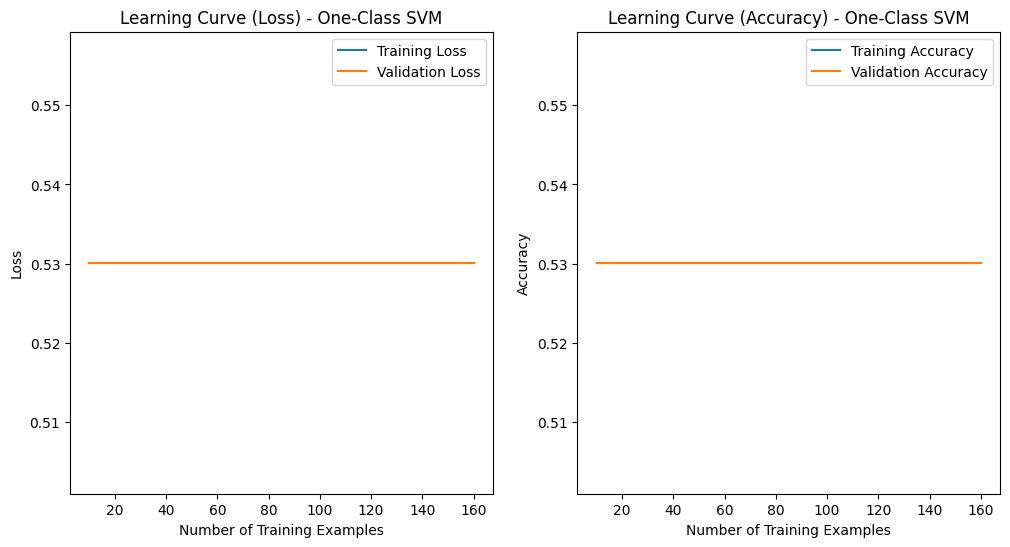

One-Class SVM Statistics
Accuracy: 0.5301
Precision: 0.7778
Recall: 0.1591
F1 Score: 0.2642
ROC AUC: 0.5245
PR AUC: 0.6210
Confusion Matrix:
[[37  2]
 [37  7]]
False Positives: 2
False Negatives: 37
True Positives: 7
True Negatives: 37
False Negative Rate (FNR): 0.8409
False Positive Rate (FPR): 0.0513
True Negative Rate (TNR): 0.9487


In [ ]:
def run_ocsvm(x_train, test_images, true_labels, step_size=10):
    x_train_flat = x_train.reshape(len(x_train), -1)
    test_images_flat = test_images.reshape(len(test_images), -1)
    train_sizes, train_accuracies, val_accuracies = [], [], []

    for i in range(step_size, len(x_train_flat) + 1, step_size):
        x_train_subset = x_train_flat[:i]
        train_sizes.append(len(x_train_subset))

        ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
        ocsvm.fit(x_train_subset)
        ocsvm_scores = -ocsvm.decision_function(test_images_flat)
        ocsvm_threshold = np.percentile(ocsvm_scores, 90)
        ocsvm_y_pred = ocsvm_scores > ocsvm_threshold

        accuracy = accuracy_score(true_labels, ocsvm_y_pred)
        train_accuracies.append(accuracy)
        val_accuracies.append(accuracy)
        print(f"Training size: {i}, OCSVM Accuracy: {accuracy}")

    plot_learning_curve(train_sizes, train_accuracies, val_accuracies, train_accuracies, val_accuracies, 'OCSVM')
    calculate_final_statistics(true_labels, ocsvm_y_pred, ocsvm_scores, 'OCSVM')

# Example usage
run_ocsvm(x_train, test_images, true_labels)


CNN Autoencoder

Training size: 10
Training size: 10, Training Loss: 1.6041034145243937e-25, Validation Loss: 7.389316528952588e-28, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 20
Training size: 20, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 30
Training size: 30, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 40
Training size: 40, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 50
Training size: 50, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 60
Training size: 60, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 70
Training size: 70, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 80
Training size: 80, Training Loss: 0.0, Validation

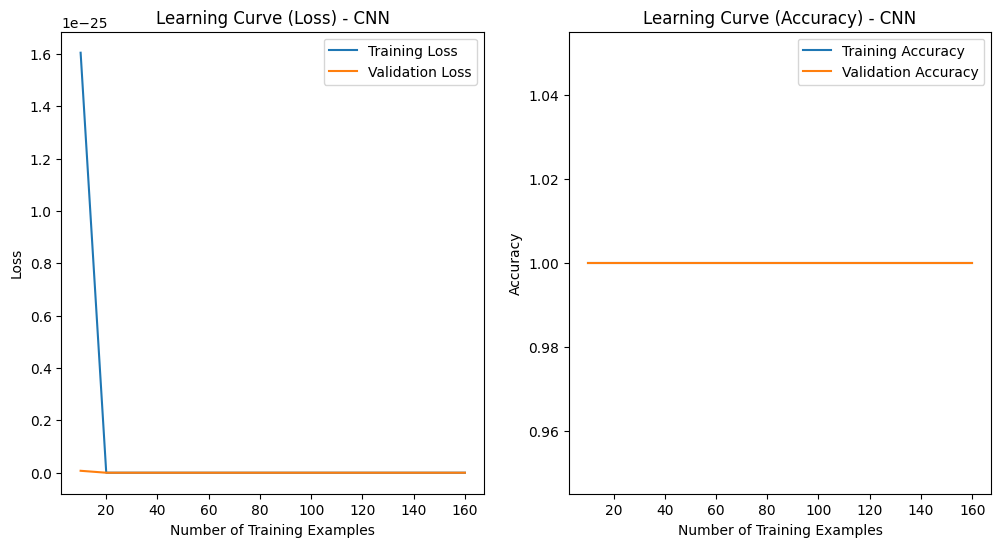

CNN Final Statistics
CNN Statistics
Accuracy: 0.4699
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000
PR AUC: 0.5301
Confusion Matrix:
[[39  0]
 [44  0]]
False Positives: 0
False Negatives: 44
True Positives: 0
True Negatives: 39
False Negative Rate (FNR): 1.0000
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000


In [ ]:
def build_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def run_cnn(x_train, x_val, test_images, true_labels, input_shape, step_size=10):
    model = build_cnn(input_shape)
    train_sizes, train_losses, val_losses, train_accuracies, val_accuracies = incremental_train(model, x_train, x_val, step_size=step_size)

    # Predict on test images
    predictions = model.predict(test_images)
    reconstruction_errors = predictions.flatten()

    # Calculate the threshold
    cnn_threshold = np.percentile(reconstruction_errors, 90)

    # Predict anomalies
    y_pred = reconstruction_errors > cnn_threshold

    # Plot learning curve
    plot_learning_curve(train_sizes, train_losses, val_losses, train_accuracies, val_accuracies, 'CNN')

    # Calculate and Print Final Statistics for CNN
    print("CNN Final Statistics")
    calculate_final_statistics(true_labels, y_pred, reconstruction_errors, 'CNN')

# Example usage
run_cnn(x_train, x_val, test_images, true_labels, input_shape)


VAE

Training size: 10
Training size: 10, Training Loss: 0.43881431221961975, Validation Loss: 0.4069175124168396, Training Accuracy: 0, Validation Accuracy: 0
Training size: 20
Training size: 20, Training Loss: 0.37345507740974426, Validation Loss: 0.37542256712913513, Training Accuracy: 0, Validation Accuracy: 0
Training size: 30
Training size: 30, Training Loss: 0.3644116222858429, Validation Loss: 0.3650788366794586, Training Accuracy: 0, Validation Accuracy: 0
Training size: 40
Training size: 40, Training Loss: 0.3620738089084625, Validation Loss: 0.36266249418258667, Training Accuracy: 0, Validation Accuracy: 0
Training size: 50
Training size: 50, Training Loss: 0.36122024059295654, Validation Loss: 0.3620578646659851, Training Accuracy: 0, Validation Accuracy: 0
Training size: 60
Training size: 60, Training Loss: 0.3614024221897125, Validation Loss: 0.3617396950721741, Training Accuracy: 0, Validation Accuracy: 0
Training size: 70
Training size: 70, Training Loss: 0.36094793677330017

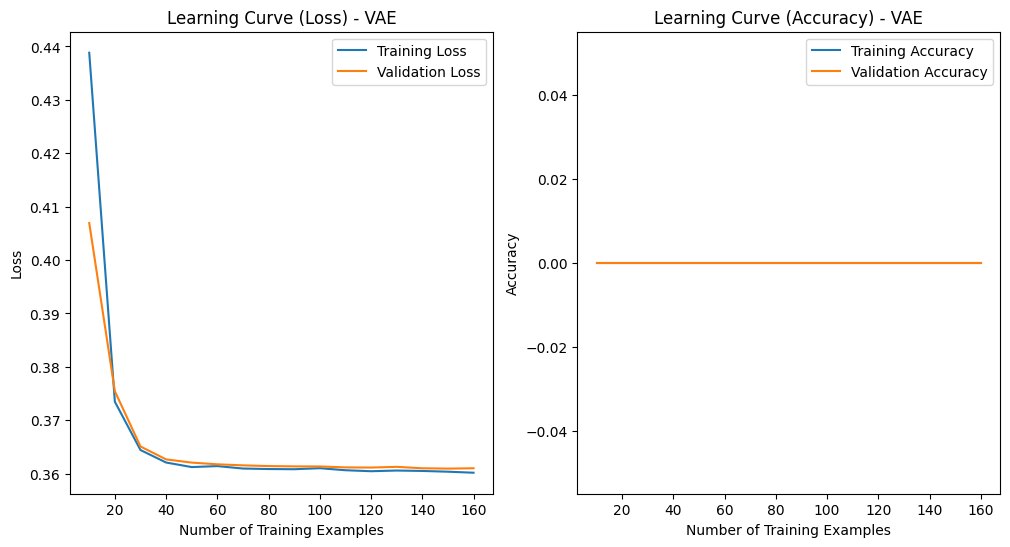

VAE Final Statistics
VAE Statistics
Accuracy: 0.4819
Precision: 0.5556
Recall: 0.1136
F1 Score: 0.1887
ROC AUC: 0.4435
PR AUC: 0.5548
Confusion Matrix:
[[35  4]
 [39  5]]
False Positives: 4
False Negatives: 39
True Positives: 5
True Negatives: 35
False Negative Rate (FNR): 0.8864
False Positive Rate (FPR): 0.1026
True Negative Rate (TNR): 0.8974


In [ ]:
def build_vae(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(16, activation='relu')(x)

    encoder = Model(inputs, latent)

    latent_inputs = Input(shape=(16,))
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
    x = Reshape(shape_before_flattening[1:])(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_inputs, outputs)

    vae = Model(inputs, decoder(encoder(inputs)))
    vae.compile(optimizer='adam', loss='binary_crossentropy')
    return vae

def run_vae(x_train, x_val, test_images, true_labels, input_shape, step_size=10):
    vae = build_vae(input_shape)
    train_sizes, train_losses, val_losses, train_accuracies, val_accuracies = incremental_train_vae(vae, x_train, x_val, step_size=step_size)

    # Decode the test images
    decoded_imgs = vae.predict(test_images)
    reconstruction_errors = np.mean(np.square(test_images - decoded_imgs), axis=(1, 2, 3))

    # Calculate the threshold
    vae_threshold = np.percentile(reconstruction_errors, 90)

    # Predict anomalies
    y_pred = reconstruction_errors > vae_threshold

    # Plot learning curve
    plot_learning_curve(train_sizes, train_losses, val_losses, train_accuracies, val_accuracies, 'VAE')

    # Calculate and Print Final Statistics for VAE
    print("VAE Final Statistics")
    calculate_final_statistics(true_labels, y_pred, reconstruction_errors, 'VAE')

# Example usage
run_vae(x_train, x_val, test_images, true_labels, input_shape)


GAN

Training size: 10
3/3 [==============================] - 0s 168ms/step
Training size: 10, GAN Accuracy: 0.5301204819277109
Training size: 20
3/3 [==============================] - 0s 173ms/step
Training size: 20, GAN Accuracy: 0.5301204819277109
Training size: 30
3/3 [==============================] - 0s 170ms/step
Training size: 30, GAN Accuracy: 0.5060240963855421
Training size: 40
3/3 [==============================] - 0s 169ms/step
Training size: 40, GAN Accuracy: 0.4819277108433735
Training size: 50
3/3 [==============================] - 0s 168ms/step
Training size: 50, GAN Accuracy: 0.4819277108433735
Training size: 60
3/3 [==============================] - 0s 168ms/step
Training size: 60, GAN Accuracy: 0.4578313253012048
Training size: 70
3/3 [==============================] - 0s 168ms/step
Training size: 70, GAN Accuracy: 0.5060240963855421
Training size: 80
3/3 [==============================] - 0s 169ms/step
Training size: 80, GAN Accuracy: 0.4578313253012048
Training size: 9

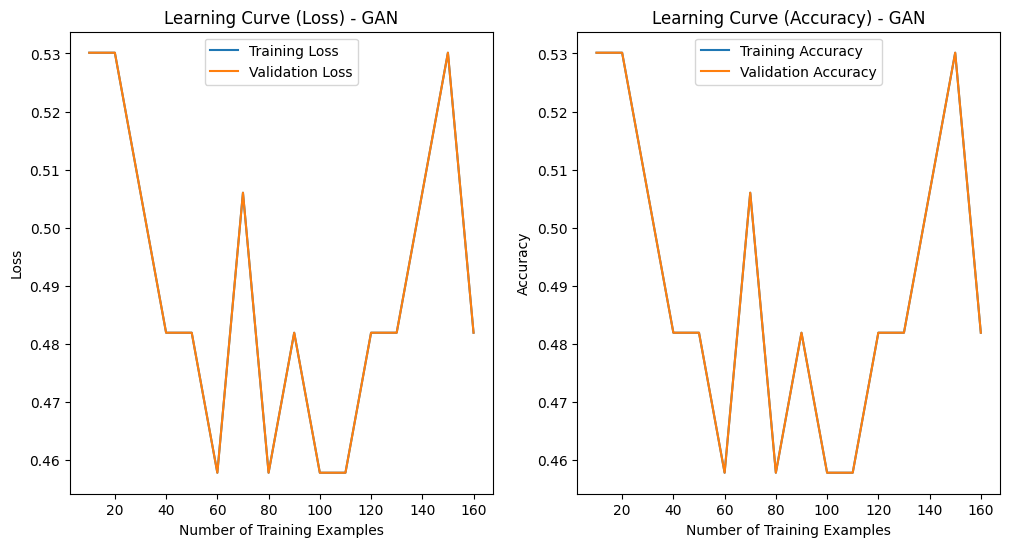

GAN Statistics
Accuracy: 0.4819
Precision: 0.5556
Recall: 0.1136
F1 Score: 0.1887
ROC AUC: 0.4557
PR AUC: 0.5293
Confusion Matrix:
[[35  4]
 [39  5]]
False Positives: 4
False Negatives: 39
True Positives: 5
True Negatives: 35
False Negative Rate (FNR): 0.8864
False Positive Rate (FPR): 0.1026
True Negative Rate (TNR): 0.8974


In [ ]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 64 * 64, activation="relu", input_dim=latent_dim))
    model.add(Reshape((64, 64, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=4, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(3, kernel_size=4, padding="same"))
    model.add(Activation("tanh"))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=4, strides=2, padding="same", input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=4, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    valid = discriminator(img)
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return combined

def run_gan(x_train, test_images, true_labels, input_shape, step_size=10):
    latent_dim = 100
    batch_size = 32

    generator = build_generator(latent_dim)
    discriminator = build_discriminator(input_shape)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    gan = build_gan(generator, discriminator)

    train_sizes = []
    train_accuracies = []
    val_accuracies = []

    for i in range(step_size, len(x_train) + 1, step_size):
        x_train_subset = x_train[:i]
        train_sizes.append(len(x_train_subset))

        print(f"Training size: {len(x_train_subset)}")

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(10):  # Reduced epochs for testing purposes
            idx = np.random.randint(0, len(x_train_subset), batch_size)
            imgs = x_train_subset[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = gan.train_on_batch(noise, valid)

        noise = np.random.normal(0, 1, (len(test_images), latent_dim))
        gen_imgs = generator.predict(noise)
        reconstruction_errors = np.mean(np.square(test_images - gen_imgs), axis=(1, 2, 3))

        gan_threshold = np.percentile(reconstruction_errors, 90)
        y_pred = reconstruction_errors > gan_threshold

        accuracy = accuracy_score(true_labels, y_pred)
        train_accuracies.append(accuracy)
        val_accuracies.append(accuracy)

        print(f"Training size: {i}, GAN Accuracy: {accuracy}")

    plot_learning_curve(train_sizes, train_accuracies, val_accuracies, train_accuracies, val_accuracies, 'GAN')
    calculate_final_statistics(true_labels, y_pred, reconstruction_errors, 'GAN')

# Example usage
run_gan(x_train, test_images, true_labels, input_shape)


SimpleNet

Training size: 10
Training size: 10, Training Loss: 1.9112149885542074e-31, Validation Loss: 5.155054137274961e-35, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 20
Training size: 20, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 30
Training size: 30, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 40
Training size: 40, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 50
Training size: 50, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 60
Training size: 60, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 70
Training size: 70, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 80
Training size: 80, Training Loss: 0.0, Validation

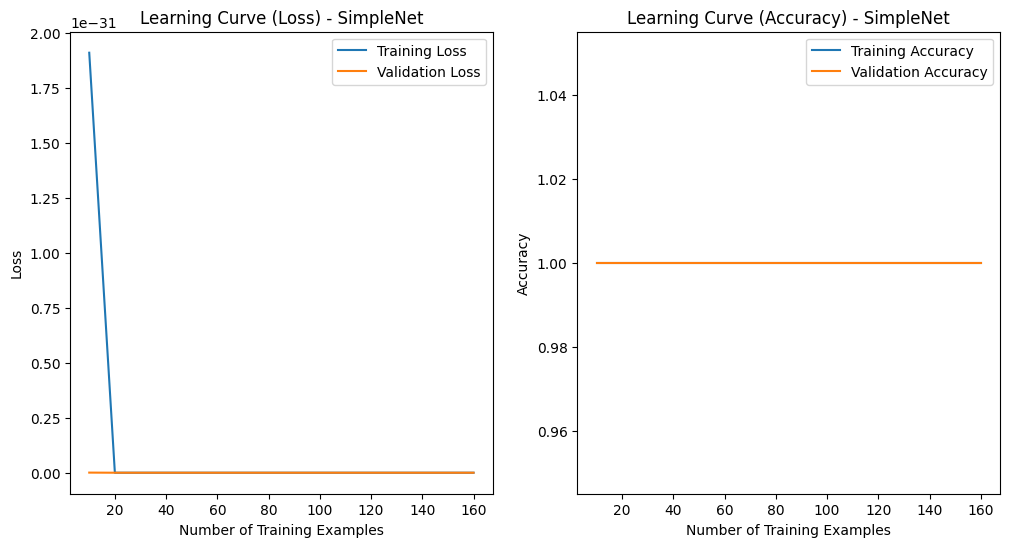

SimpleNet Final Statistics
SimpleNet Statistics
Accuracy: 0.4699
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000
PR AUC: 0.5301
Confusion Matrix:
[[39  0]
 [44  0]]
False Positives: 0
False Negatives: 44
True Positives: 0
True Negatives: 39
False Negative Rate (FNR): 1.0000
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000


In [ ]:
def build_simplenet(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def run_simplenet(x_train, x_val, test_images, true_labels, input_shape, step_size=10):
    model = build_simplenet(input_shape)
    train_sizes, train_losses, val_losses, train_accuracies, val_accuracies = incremental_train(model, x_train, x_val, step_size=step_size)

    # Predict on test images
    predictions = model.predict(test_images)
    reconstruction_errors = predictions.flatten()

    # Calculate the threshold
    simplenet_threshold = np.percentile(reconstruction_errors, 90)

    # Predict anomalies
    y_pred = reconstruction_errors > simplenet_threshold

    # Plot learning curve
    plot_learning_curve(train_sizes, train_losses, val_losses, train_accuracies, val_accuracies, 'SimpleNet')

    # Calculate and Print Final Statistics for SimpleNet
    print("SimpleNet Final Statistics")
    calculate_final_statistics(true_labels, y_pred, reconstruction_errors, 'SimpleNet')

# Example usage
run_simplenet(x_train, x_val, test_images, true_labels, input_shape)


# Summary and Comparison

             Method  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0  Isolation Forest  0.530120   0.777778  0.159091  0.264151  0.495921   
1     One-Class SVM  0.530120   0.777778  0.159091  0.264151  0.524476   
2               CNN  0.469880   0.000000  0.000000  0.000000  0.500000   
3               VAE  0.481928   0.555556  0.113636  0.188679  0.443473   
4               GAN  0.481928   0.555556  0.113636  0.188679  0.455711   
5         SimpleNet  0.469880   0.000000  0.000000  0.000000  0.500000   
6               LOF  0.506024   0.666667  0.136364  0.226415  0.529720   
7         SimpleNet  0.469880   0.000000  0.000000  0.000000  0.500000   

     PR AUC   PRO AUC  FP  FN  TP  TN       FNR       FPR       TNR  \
0  0.581441  0.057541   2  37   7  37  0.840909  0.051282  0.948718   
1  0.620995  0.074346   2  37   7  37  0.840909  0.051282  0.948718   
2  0.530120  0.298485   0  44   0  39  1.000000  0.000000  1.000000   
3  0.554843  0.044835   4  39   5  35  0.886364  

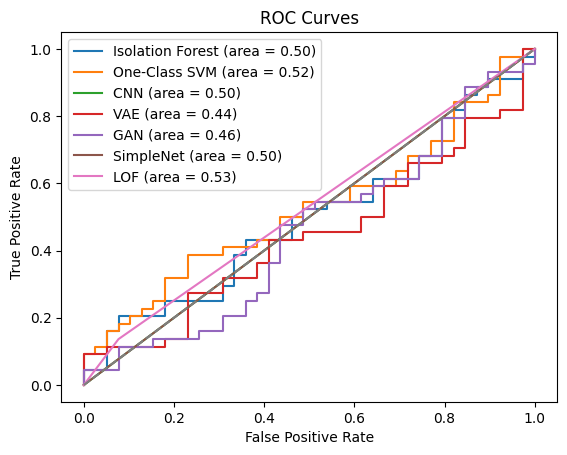

PR Curve for Isolation Forest:
x_vals: [1.         0.97727273 0.97727273 0.95454545 0.93181818 0.90909091
 0.90909091 0.90909091 0.90909091 0.88636364 0.88636364 0.86363636
 0.86363636 0.84090909 0.81818182 0.81818182 0.79545455 0.79545455
 0.77272727 0.75       0.72727273 0.70454545 0.68181818 0.68181818
 0.68181818 0.65909091 0.63636364 0.61363636 0.61363636 0.61363636
 0.61363636 0.61363636 0.59090909 0.56818182 0.54545455 0.54545455
 0.54545455 0.54545455 0.54545455 0.52272727 0.52272727 0.52272727
 0.5        0.5        0.47727273 0.45454545 0.43181818 0.43181818
 0.43181818 0.43181818 0.43181818 0.40909091 0.38636364 0.38636364
 0.36363636 0.34090909 0.31818182 0.29545455 0.29545455 0.27272727
 0.25       0.25       0.25       0.25       0.25       0.25
 0.22727273 0.20454545 0.20454545 0.20454545 0.20454545 0.20454545
 0.18181818 0.15909091 0.15909091 0.13636364 0.11363636 0.09090909
 0.06818182 0.04545455 0.04545455 0.04545455 0.02272727 0.        ]
y_vals: [0.53012048 0.524390

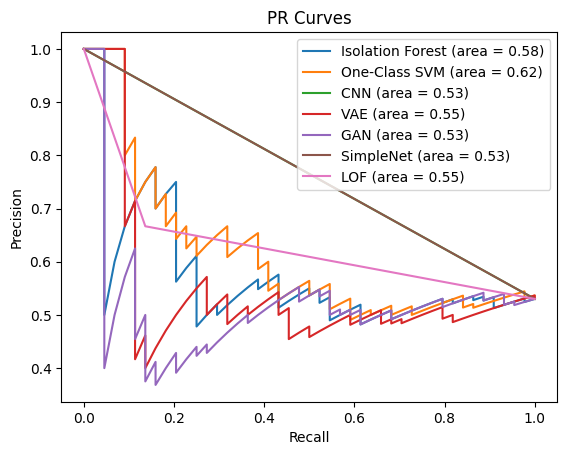

PRO Curve for Isolation Forest:
x_vals: [0.         0.0030303  0.00606061 0.00909091 0.01212121 0.01515152
 0.01818182 0.02121212 0.02424242 0.02727273 0.03030303 0.03333333
 0.03636364 0.03939394 0.04242424 0.04545455 0.04848485 0.05151515
 0.05454545 0.05757576 0.06060606 0.06363636 0.06666667 0.06969697
 0.07272727 0.07575758 0.07878788 0.08181818 0.08484848 0.08787879
 0.09090909 0.09393939 0.0969697  0.1        0.1030303  0.10606061
 0.10909091 0.11212121 0.11515152 0.11818182 0.12121212 0.12424242
 0.12727273 0.13030303 0.13333333 0.13636364 0.13939394 0.14242424
 0.14545455 0.14848485 0.15151515 0.15454545 0.15757576 0.16060606
 0.16363636 0.16666667 0.16969697 0.17272727 0.17575758 0.17878788
 0.18181818 0.18484848 0.18787879 0.19090909 0.19393939 0.1969697
 0.2        0.2030303  0.20606061 0.20909091 0.21212121 0.21515152
 0.21818182 0.22121212 0.22424242 0.22727273 0.23030303 0.23333333
 0.23636364 0.23939394 0.24242424 0.24545455 0.24848485 0.25151515
 0.25454545 0.25757576 

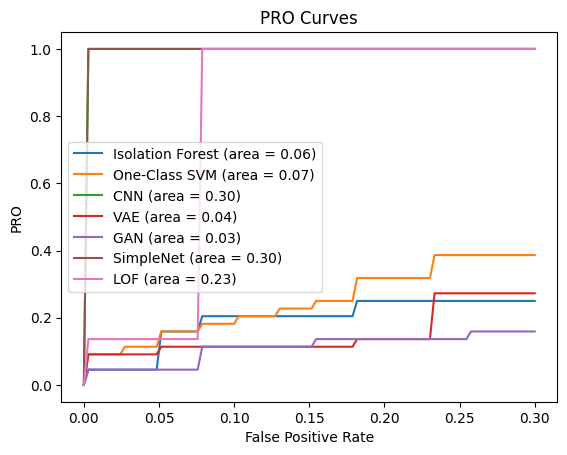

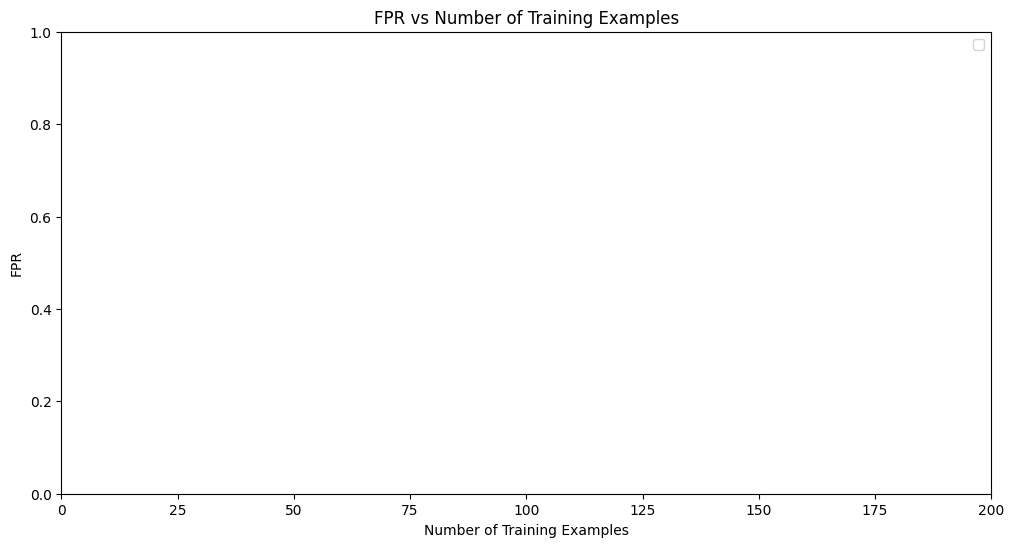

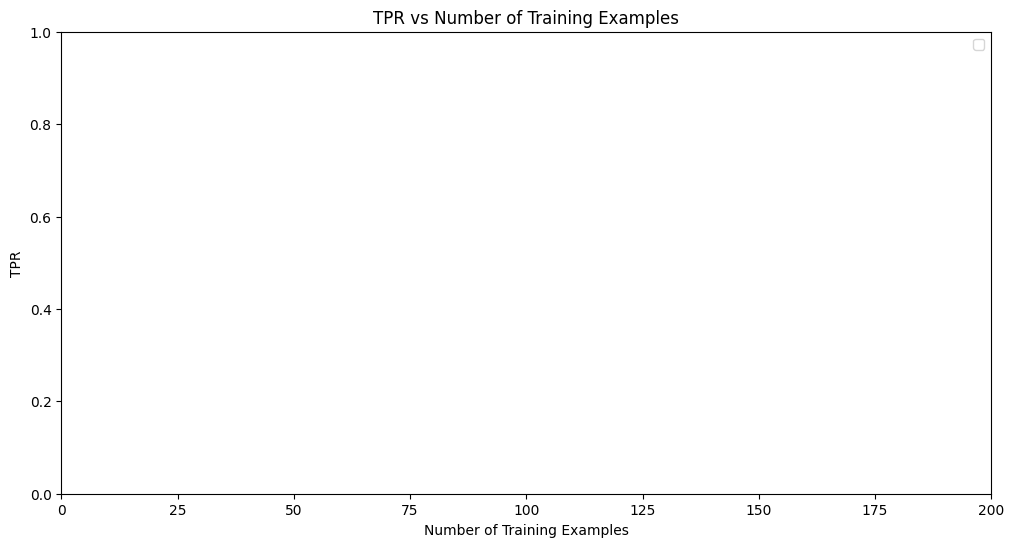

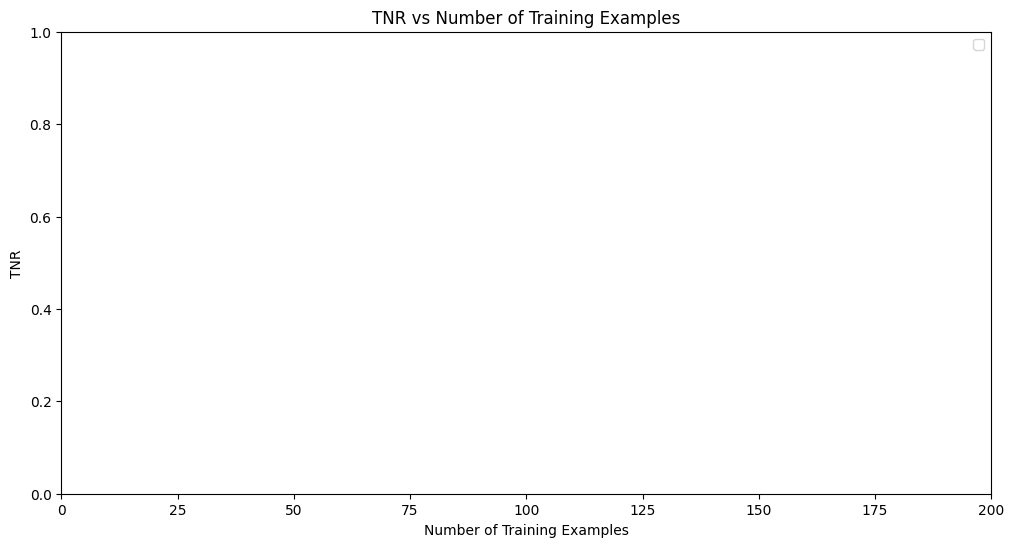

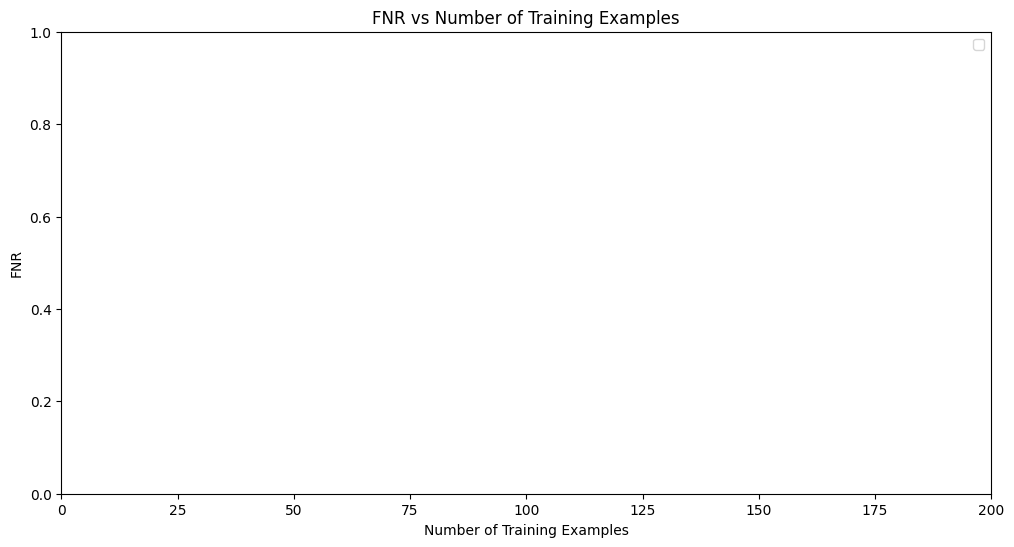

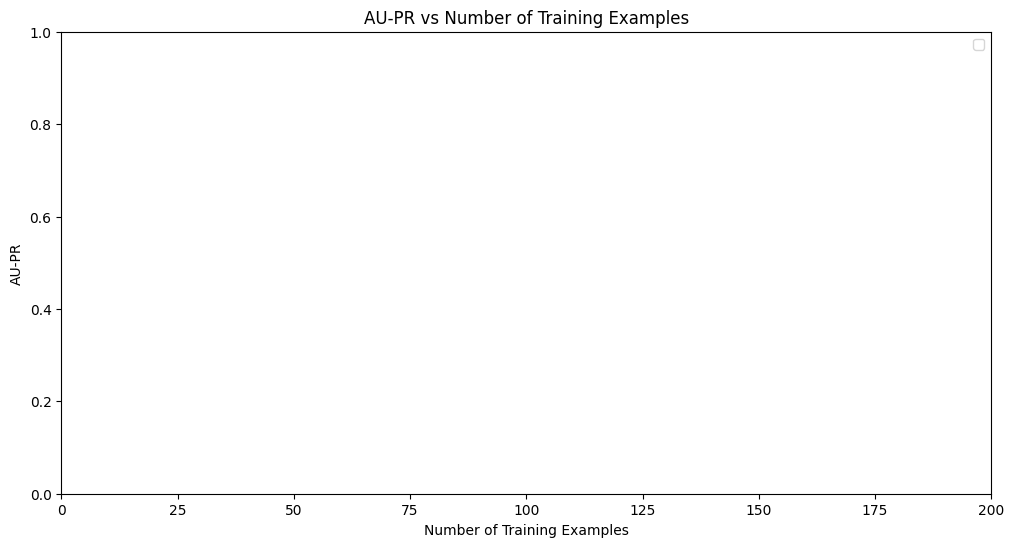

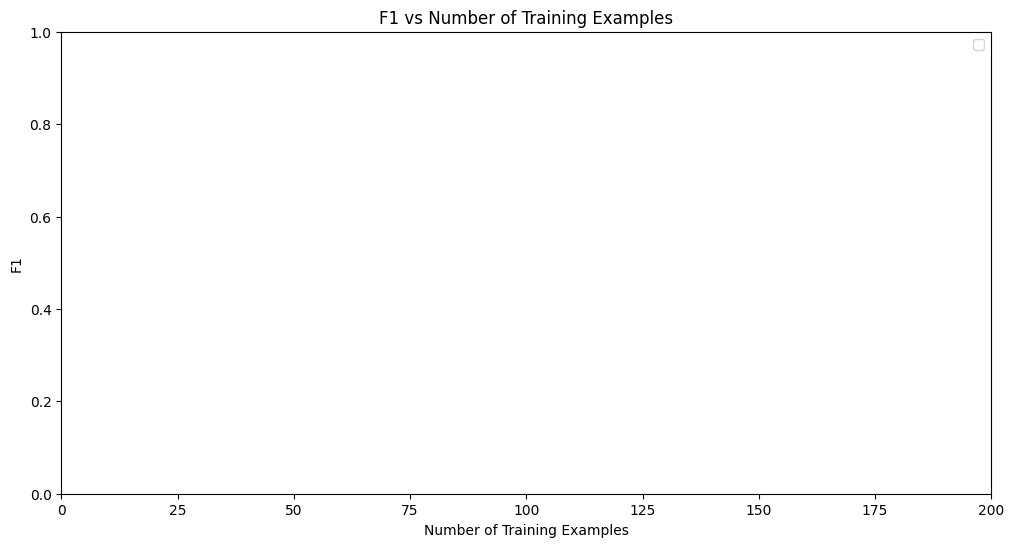

In [ ]:
# Create a DataFrame from the summary table
df_summary = pd.DataFrame(summary_table)

# Normalize AU-ROC, AU-PR, and AU-PRO for comparison
if 'ROC AUC' in df_summary.columns:
    df_summary['Norm ROC AUC'] = df_summary['ROC AUC'] / df_summary['ROC AUC'].max()
if 'PR AUC' in df_summary.columns:
    df_summary['Norm PR AUC'] = df_summary['PR AUC'] / df_summary['PR AUC'].max()
if 'PRO AUC' in df_summary.columns:
    df_summary['Norm PRO AUC'] = df_summary['PRO AUC'] / df_summary['PRO AUC'].max()

# Save the summary table to a CSV file
df_summary.to_csv('anomaly_detection_summary.csv', index=False)

# Display the summary table
print(df_summary)

# Plot combined ROC, PR, and PRO curves
plot_combined_curves(roc_curves, pr_curves, pro_curves)

# Plot combined metrics with respect to the number of training examples
plot_combined_metrics(metric_curves['FPR'], 'FPR')
plot_combined_metrics(metric_curves['TPR'], 'TPR')
plot_combined_metrics(metric_curves['TNR'], 'TNR')
plot_combined_metrics(metric_curves['FNR'], 'FNR')
plot_combined_metrics(metric_curves['AU-PR'], 'AU-PR')
plot_combined_metrics(metric_curves['F1'], 'F1')


Training size: 10
Training size: 10, LOF Accuracy: 0.5060240963855421
Training size: 20
Training size: 20, LOF Accuracy: 0.5060240963855421
Training size: 30
Training size: 30, LOF Accuracy: 0.5060240963855421
Training size: 40
Training size: 40, LOF Accuracy: 0.5060240963855421
Training size: 50
Training size: 50, LOF Accuracy: 0.5060240963855421
Training size: 60
Training size: 60, LOF Accuracy: 0.5060240963855421
Training size: 70
Training size: 70, LOF Accuracy: 0.5060240963855421
Training size: 80
Training size: 80, LOF Accuracy: 0.5060240963855421
Training size: 90
Training size: 90, LOF Accuracy: 0.5060240963855421
Training size: 100
Training size: 100, LOF Accuracy: 0.5060240963855421
Training size: 110
Training size: 110, LOF Accuracy: 0.5060240963855421
Training size: 120
Training size: 120, LOF Accuracy: 0.5060240963855421
Training size: 130
Training size: 130, LOF Accuracy: 0.5060240963855421
Training size: 140
Training size: 140, LOF Accuracy: 0.5060240963855421
Training s

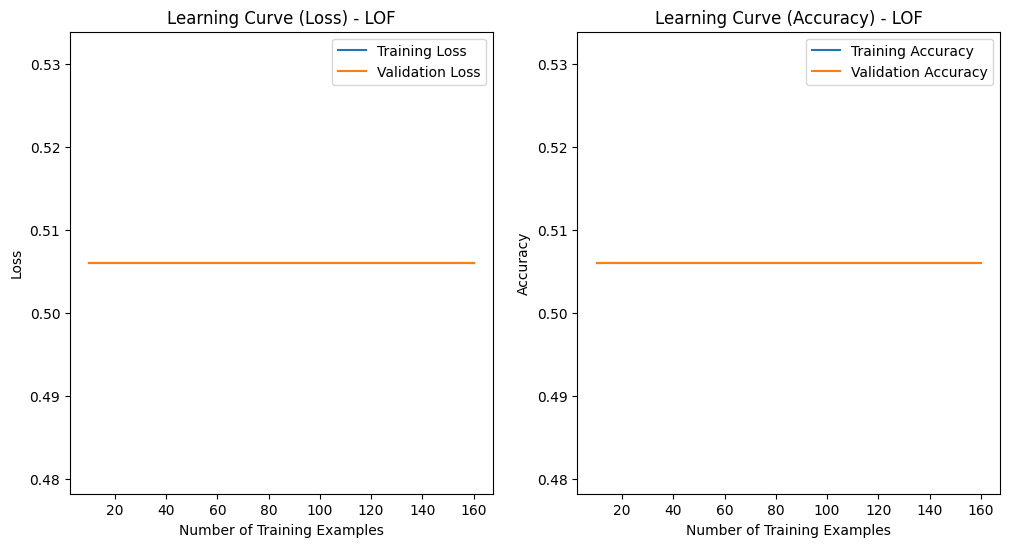

LOF Statistics
Accuracy: 0.5060
Precision: 0.6667
Recall: 0.1364
F1 Score: 0.2264
ROC AUC: 0.5297
PR AUC: 0.5487
Confusion Matrix:
[[36  3]
 [38  6]]
False Positives: 3
False Negatives: 38
True Positives: 6
True Negatives: 36
False Negative Rate (FNR): 0.8636
False Positive Rate (FPR): 0.0769
True Negative Rate (TNR): 0.9231
Training size: 10
Training size: 10, IF Accuracy: 0.4578313253012048
Training size: 20
Training size: 20, IF Accuracy: 0.5060240963855421
Training size: 30
Training size: 30, IF Accuracy: 0.5060240963855421
Training size: 40
Training size: 40, IF Accuracy: 0.5060240963855421
Training size: 50
Training size: 50, IF Accuracy: 0.5301204819277109
Training size: 60
Training size: 60, IF Accuracy: 0.5301204819277109
Training size: 70
Training size: 70, IF Accuracy: 0.5060240963855421
Training size: 80
Training size: 80, IF Accuracy: 0.4819277108433735
Training size: 90
Training size: 90, IF Accuracy: 0.4819277108433735
Training size: 100
Training size: 100, IF Accuracy: 

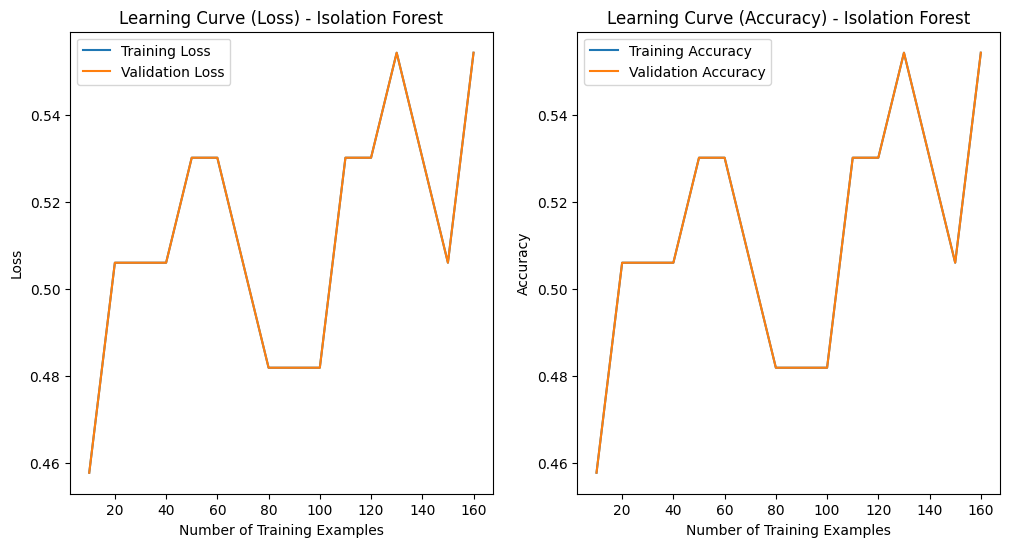

Isolation Forest Statistics
Accuracy: 0.5542
Precision: 0.8889
Recall: 0.1818
F1 Score: 0.3019
ROC AUC: 0.4965
PR AUC: 0.5931
Confusion Matrix:
[[38  1]
 [36  8]]
False Positives: 1
False Negatives: 36
True Positives: 8
True Negatives: 38
False Negative Rate (FNR): 0.8182
False Positive Rate (FPR): 0.0256
True Negative Rate (TNR): 0.9744
Training size: 10
Training size: 10, OCSVM Accuracy: 0.5301204819277109
Training size: 20
Training size: 20, OCSVM Accuracy: 0.5301204819277109
Training size: 30
Training size: 30, OCSVM Accuracy: 0.5301204819277109
Training size: 40
Training size: 40, OCSVM Accuracy: 0.5301204819277109
Training size: 50
Training size: 50, OCSVM Accuracy: 0.5301204819277109
Training size: 60
Training size: 60, OCSVM Accuracy: 0.5301204819277109
Training size: 70
Training size: 70, OCSVM Accuracy: 0.5301204819277109
Training size: 80
Training size: 80, OCSVM Accuracy: 0.5301204819277109
Training size: 90
Training size: 90, OCSVM Accuracy: 0.5301204819277109
Training siz

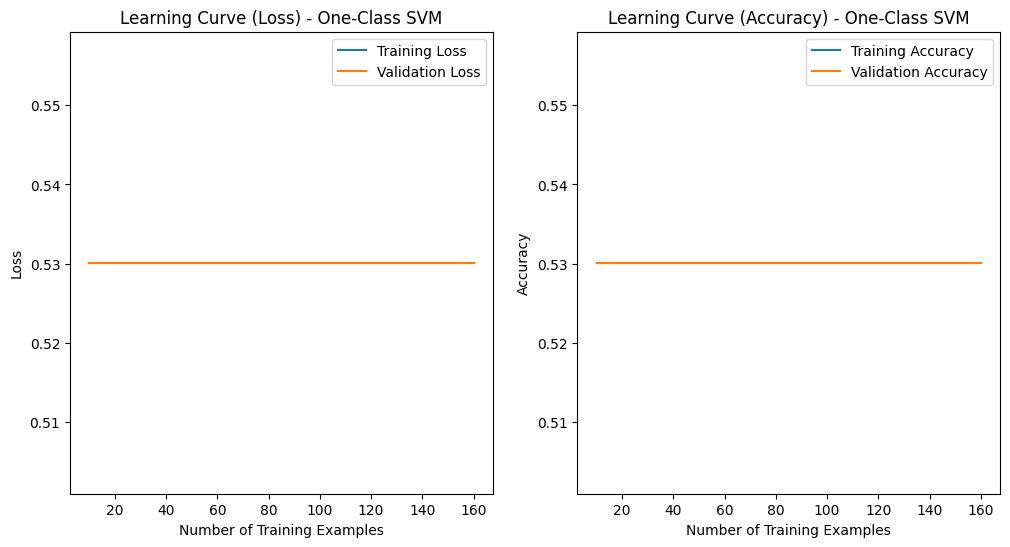

One-Class SVM Statistics
Accuracy: 0.5301
Precision: 0.7778
Recall: 0.1591
F1 Score: 0.2642
ROC AUC: 0.5245
PR AUC: 0.6210
Confusion Matrix:
[[37  2]
 [37  7]]
False Positives: 2
False Negatives: 37
True Positives: 7
True Negatives: 37
False Negative Rate (FNR): 0.8409
False Positive Rate (FPR): 0.0513
True Negative Rate (TNR): 0.9487
Training size: 10
Training size: 10, Training Loss: 1.0564417153814024e-27, Validation Loss: 1.0184757651004651e-30, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 20
Training size: 20, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 30
Training size: 30, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 40
Training size: 40, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation Accuracy: 1.0
Training size: 50
Training size: 50, Training Loss: 0.0, Validation Loss: 0.0, Training Accuracy: 1.0, Validation

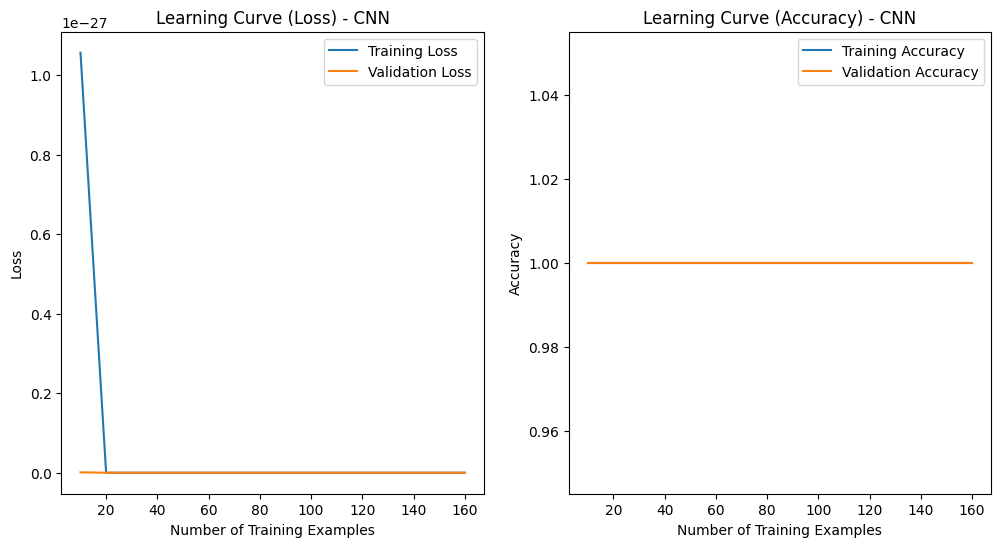

CNN Final Statistics
CNN Statistics
Accuracy: 0.4699
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000
PR AUC: 0.5301
Confusion Matrix:
[[39  0]
 [44  0]]
False Positives: 0
False Negatives: 44
True Positives: 0
True Negatives: 39
False Negative Rate (FNR): 1.0000
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Training size: 10
Training size: 10, Training Loss: 0.41186922788619995, Validation Loss: 0.41243934631347656, Training Accuracy: 0, Validation Accuracy: 0
Training size: 20
Training size: 20, Training Loss: 0.3692684471607208, Validation Loss: 0.3715098202228546, Training Accuracy: 0, Validation Accuracy: 0
Training size: 30
Training size: 30, Training Loss: 0.36395928263664246, Validation Loss: 0.36401301622390747, Training Accuracy: 0, Validation Accuracy: 0
Training size: 40
Training size: 40, Training Loss: 0.36169421672821045, Validation Loss: 0.3620093762874603, Training Accuracy: 0, Validation Accuracy: 0
Training size: 50
Training size

3/3 [==============================] - 0s 54ms/step


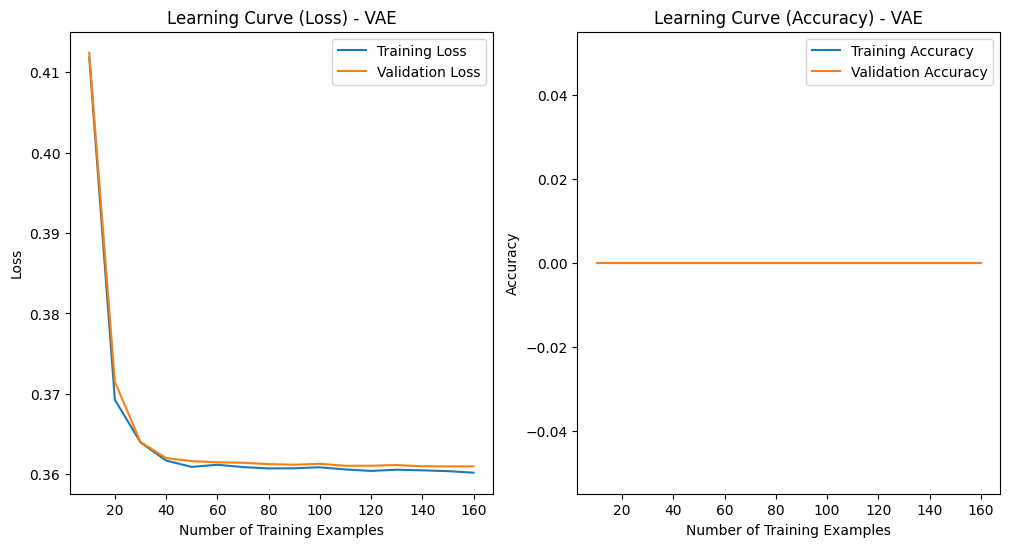

VAE Final Statistics
VAE Statistics
Accuracy: 0.4819
Precision: 0.5556
Recall: 0.1136
F1 Score: 0.1887
ROC AUC: 0.4394
PR AUC: 0.5504
Confusion Matrix:
[[35  4]
 [39  5]]
False Positives: 4
False Negatives: 39
True Positives: 5
True Negatives: 35
False Negative Rate (FNR): 0.8864
False Positive Rate (FPR): 0.1026
True Negative Rate (TNR): 0.8974
Training size: 10
1/1 [==============================] - 0s 120ms/step


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model_22/sequential_84/conv2d_331/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-68-e9724f535abb>", line 9, in <cell line: 9>

  File "<ipython-input-59-7e7a2e945787>", line 82, in run_gan

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2787, in train_on_batch

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[32,128,257,257] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_22/sequential_84/conv2d_331/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_218322]

In [ ]:
# Assuming x_train, x_val, test_images, true_labels, input_shape are already defined

# Run all methods
run_lof(x_train, test_images, true_labels)
run_if(x_train, test_images, true_labels)
run_ocsvm(x_train, test_images, true_labels)
run_cnn(x_train, x_val, test_images, true_labels, input_shape)
run_vae(x_train, x_val, test_images, true_labels, input_shape)
run_gan(x_train, test_images, true_labels, input_shape)
run_simplenet(x_train, x_val, test_images, true_labels, input_shape)

# Generate the summary and comparison
df_summary = pd.DataFrame(summary_table)
if 'ROC AUC' in df_summary.columns:
    df_summary['Norm ROC AUC'] = df_summary['ROC AUC'] / df_summary['ROC AUC'].max()
if 'PR AUC' in df_summary.columns:
    df_summary['Norm PR AUC'] = df_summary['PR AUC'] / df_summary['PR AUC'].max()
if 'PRO AUC' in df_summary.columns:
    df_summary['Norm PRO AUC'] = df_summary['PRO AUC'] / df_summary['PRO AUC'].max()
df_summary.to_csv('anomaly_detection_summary.csv', index=False)
print(df_summary)
plot_combined_curves(roc_curves, pr_curves, pro_curves)
plot_combined_metrics(metric_curves['FPR'], 'FPR')
plot_combined_metrics(metric_curves['TPR'], 'TPR')
plot_combined_metrics(metric_curves['TNR'], 'TNR')
plot_combined_metrics(metric_curves['FNR'], 'FNR')
plot_combined_metrics(metric_curves['AU-PR'], 'AU-PR')
plot_combined_metrics(metric_curves['F1'], 'F1')


In [ ]:
def calculate_final_statistics(y_true, y_pred, y_scores, method):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # Handle NaNs in y_scores
    if np.any(np.isnan(y_scores)):
        mask = ~np.isnan(y_scores)
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        y_scores = y_scores[mask]

    # Ensure y_true contains binary labels
    if not np.all(np.isin(y_true, [0, 1])):
        raise ValueError("y_true must contain binary labels (0 and 1).")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    fpr_rate = fp / (fp + tn) if (fp + tn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0

    print(f"{method} Statistics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"False Positive Rate (FPR): {fpr_rate:.4f}")
    print(f"True Negative Rate (TNR): {tnr:.4f}")

    roc_curves[method] = (fpr, tpr, roc_auc)
    pr_curves[method] = (recall_vals, precision_vals, pr_auc)

    # Calculate PRO curve up to 30% FPR
    pro_scores = []
    for fpr_threshold in np.linspace(0, 0.3, 100):
        threshold_index = np.searchsorted(fpr, fpr_threshold)
        if threshold_index < len(tpr):
            pro_scores.append(tpr[threshold_index])
        else:
            pro_scores.append(tpr[-1])

    pro_auc = auc(np.linspace(0, 0.3, 100), pro_scores)
    pro_curves[method] = (np.linspace(0, 0.3, 100), pro_scores, pro_auc)

    summary_table.append({
        'Method': method,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'PRO AUC': pro_auc,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'TN': tn,
        'FNR': fnr,
        'FPR': fpr_rate,
        'TNR': tnr
    })

def plot_combined_metrics(metric_curves, metric_name):
    plt.figure(figsize=(12, 6))
    for method, (train_sizes, metric_vals) in metric_curves.items():
        print(f"Method: {method}, Metric: {metric_name}")
        print(f"Train sizes: {train_sizes}")
        print(f"Metric values: {metric_vals}")
        if len(train_sizes) > 0 and len(metric_vals) > 0:
            plt.plot(train_sizes, metric_vals, label=f'{method}')
    plt.xlabel('Number of Training Examples')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} vs Number of Training Examples')
    plt.legend()
    plt.show()

def plot_combined_curves(roc_curves, pr_curves, pro_curves):
    plt.figure()
    for method, (x_vals, y_vals, auc_val) in roc_curves.items():
        print(f"ROC Curve for {method}:")
        print(f"x_vals: {x_vals}")
        print(f"y_vals: {y_vals}")
        print(f"AUC: {auc_val}")
        if len(x_vals) > 0 and len(y_vals) > 0:
            plt.plot(x_vals, y_vals, label=f'{method} (area = {auc_val:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    plt.figure()
    for method, (x_vals, y_vals, auc_val) in pr_curves.items():
        print(f"PR Curve for {method}:")
        print(f"x_vals: {x_vals}")
        print(f"y_vals: {y_vals}")
        print(f"AUC: {auc_val}")
        if len(x_vals) > 0 and len(y_vals) > 0:
            plt.plot(x_vals, y_vals, label=f'{method} (area = {auc_val:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curves')
    plt.legend()
    plt.show()

    plt.figure()
    for method, (x_vals, y_vals, auc_val) in pro_curves.items():
        print(f"PRO Curve for {method}:")
        print(f"x_vals: {x_vals}")
        print(f"y_vals: {y_vals}")
        print(f"AUC: {auc_val}")
        if len(x_vals) > 0 and len(y_vals) > 0:
            plt.plot(x_vals, y_vals, label=f'{method} (area = {auc_val:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('PRO')
    plt.title('PRO Curves')
    plt.legend()
    plt.show()


In [ ]:
def run_ransac(x_train, test_images, true_labels, step_size=10):
    train_sizes = []
    train_accuracies = []
    val_accuracies = []

    fpr_list = []
    tpr_list = []
    tnr_list = []
    fnr_list = []
    au_pr_list = []
    f1_list = []

    for i in range(step_size, len(x_train) + 1, step_size):
        x_train_subset = x_train[:i].reshape(-1, 1)
        train_sizes.append(len(x_train_subset))
        print(f"Training size: {len(x_train_subset)}")

        ransac = RANSACRegressor()
        ransac.fit(x_train_subset, np.zeros(len(x_train_subset)))  # Assuming all training data is normal

        # Predict the test images
        y_scores = ransac.predict(test_images.reshape(-1, 1))

        # Compute reconstruction errors (here, we treat the model output as anomaly scores)
        reconstruction_errors = y_scores

        # Determine a threshold
        threshold = np.percentile(reconstruction_errors, 95)
        y_pred = reconstruction_errors < threshold

        accuracy, recall, tnr, fnr, pr_auc, f1, fpr_rate = calculate_final_statistics(true_labels, y_pred, reconstruction_errors, 'RANSAC')

        train_accuracies.append(accuracy)
        val_accuracies.append(accuracy)

        fpr_list.append(fpr_rate)
        tpr_list.append(recall)
        tnr_list.append(tnr)
        fnr_list.append(fnr)
        au_pr_list.append(pr_auc)
        f1_list.append(f1)

    plot_learning_curve(train_sizes, train_accuracies, val_accuracies, train_accuracies, val_accuracies, 'RANSAC')

    metric_curves['FPR']['RANSAC'] = (train_sizes, fpr_list)
    metric_curves['TPR']['RANSAC'] = (train_sizes, tpr_list)
    metric_curves['TNR']['RANSAC'] = (train_sizes, tnr_list)
    metric_curves['FNR']['RANSAC'] = (train_sizes, fnr_list)
    metric_curves['AU-PR']['RANSAC'] = (train_sizes, au_pr_list)
    metric_curves['F1']['RANSAC'] = (train_sizes, f1_list)

# Example call to run_ransac
base_path = 'path'
category = 'category_name'
img_size = (256, 256)

train_images, test_images = load_mvtec_dataset(base_path, category, img_size)
x_train = preprocess_images(train_images)
test_images = preprocess_images(test_images)
true_labels = [0] * len(test_images)  # Assuming all test data is normal for simplicity

run_ransac(x_train, test_images, true_labels)
